In [1]:
import torch
import torch.nn as nn
from pathlib import Path
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from math import *
from random import gauss,seed
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import seaborn

In [2]:
from PythonModules.RESNET import RESNET 

In [3]:
trajdict = np.load('output.npz')
import ast
#params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [4]:
batch_size = 500
train_set = np.vstack([traj_open_train[1000:81000:2], traj_closed_train[1000:81000:2] ] )

In [5]:
inputData = torch.from_numpy(train_set[: ,:4]).type('torch.FloatTensor').to('cuda')
dataSet32 = torch.from_numpy( np.load('NewDataSet32.npy')[:80000] ).type('torch.FloatTensor').to('cuda')

In [6]:
dataSet32 = dataSet32.unsqueeze(1)

In [ ]:
newDataSet = []

In [ ]:
for eachSample in dataSet32:
    diff = 36 - eachSample.sum(axis=1).sum(axis=1)
    tp = eachSample + (eachSample*diff)/eachSample.sum(axis=1).sum(axis=1)
    newDataSet.append(tp.to('cpu').numpy())

In [ ]:
dataSet32 = dataSet32.type('torch.DoubleTensor').to('cuda')

In [ ]:
dataSet32 = torch.from_numpy(np.array(newDataSet)).type('torch.FloatTensor').to('cuda')

In [ ]:
print(torch.device("cuda:0"))

In [ ]:
dataSet32 = dataSet32.to('cpu').type('torch.DoubleTensor').to('cuda')

In [7]:
totalLoss =0.0

In [8]:
train_loader = torch.utils.data.DataLoader(inputData.type('torch.FloatTensor').to('cuda'), batch_size=batch_size)

In [ ]:
testInputData = torch.from_numpy(train_set[70000:,:4]).type('torch.DoubleTensor').to('cuda')
testDataSet32 = torch.from_numpy( np.load('DataSet32.npy')[70000:] ).type('torch.DoubleTensor').to('cuda').unsqueeze(1)

In [ ]:
test_loader = torch.utils.data.DataLoader(testInputData.to('cuda'), batch_size=batch_size)

In [9]:
class DensityEstimator(nn.Module):
    def __init__(self,dimer_atoms,output_dim):
        super(DensityEstimator, self).__init__()
        self.dimer_atoms = dimer_atoms
        self.hidden_dim = 16
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.fc1 = nn.Linear(self.dimer_atoms, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim*4)
        self.fc3 = nn.Linear(self.hidden_dim*4, self.hidden_dim*4*4)
        #self.lstm = nn.LSTM(hidden_dim, output_dim)
        #self.fc3 = nn.Linear(self.hidden_dim*4*4, hidden_dim*4)
        self.fc4 = nn.Linear(self.hidden_dim*4*4, output_dim)
    
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        #out,_ = self.lstm(out.view(self.boxes,1,-1))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out) )
        out = self.relu(self.fc4(out))
        out = 30.3*torch.softmax(out,1)
        return out

In [10]:
class combineModel(nn.Module):
    def __init__(self,model1,model2,model3):
        super(combineModel,self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
    
    def forward(self,inp):
        out = self.model1(inp)
        out = torch.reshape(out,(out.shape[0],1,8,8))
        #print(out)
        o1 = out
        out = self.model2(out)
        o2 = out
        #out = 36*torch.softmax( torch.reshape(out,(out.shape[0],16*16)), 1)
        #print(out.shape[0])
        #out = torch.reshape(out,(out.shape[0],1,16,16))
        
        #print(out)
        out = self.model3(out)
        #out = 36*torch.softmax( torch.reshape(out,(out.shape[0],32*32)), 1)
        #out = torch.reshape(out,(out.shape[0],1,32,32))
        
        return out

In [11]:
model1 = DensityEstimator(4,64).to('cuda')
model2 = RESNET().to('cuda')
model3 = RESNET().to('cuda')

In [ ]:
model1.load_state_dict(torch.load("ParticleTo8x8"))
model1.eval()

In [ ]:
model2.load_state_dict(torch.load("DenseEstimResNet8-16"))
model2.eval()

In [ ]:
model3.load_state_dict(torch.load("DenseEstimResNet"))
model3.eval()

In [12]:
CombineModel = combineModel(model1,model2,model3).type('torch.FloatTensor').to('cuda')

In [34]:
adOptimizer = optim.Adam(CombineModel.parameters(),lr =0.00001)

In [14]:
Epochs = 100

In [15]:
arr = torch.from_numpy(np.tile(np.array([0.025]),(500,32,32))).to('cuda')

In [16]:
arr = arr.unsqueeze(1).type('torch.cuda.FloatTensor')

In [15]:
tl = []

In [16]:
myLoss = nn.MSELoss()

In [35]:
for epoch in range(Epochs):
    totalLoss = 0.0
    print(epoch)
    #if((epoch+1)%2 == 0):
    #    torch.save(CombineModel.state_dict(), 'NewCombineDensityEstimator4-64')
    for i,data in enumerate(train_loader,1):
        adOptimizer.zero_grad()
        out = CombineModel(data)
        #print(out)
        #print(out)
        #loss = torch.sqrt( myLoss(out, dataSet32[(i-1)*batch_size:i*batch_size]) )
        #print(loss.type())
        loss =  (out- dataSet32[(i-1)*batch_size:i*batch_size])/dataSet32[(i-1)*batch_size:i*batch_size]
        loss = loss.squeeze()
        loss = torch.reshape(loss,(loss.shape[0],32*32))
        #print(loss.shape)
        loss = torch.abs(loss)
        loss =loss.mean()
        
        loss.backward()
        print(i,loss.item())
        totalLoss += loss.item()
        if(math.isnan(loss.item()) or math.isinf(loss.item())):
            break
        adOptimizer.step()
    if(math.isnan(totalLoss) or math.isinf(totalLoss)):
            break
    tl.append(totalLoss)
    print(totalLoss)

0
1 0.23576493561267853
2 0.21900370717048645
3 0.24421542882919312
4 0.21505042910575867
5 0.23907509446144104
6 0.24114179611206055
7 0.21730858087539673
8 0.21207191050052643
9 0.21102797985076904
10 0.21942822635173798
11 0.22523793578147888
12 0.2139413207769394
13 0.21845529973506927
14 0.2249535471200943
15 0.21525555849075317
16 0.22386056184768677
17 0.22958967089653015
18 0.2699171006679535
19 0.2607508897781372
20 0.2659819424152374
21 0.2588357627391815
22 0.22747690975666046
23 0.19840113818645477
24 0.21021300554275513
25 0.2193431258201599
26 0.2150326669216156
27 0.22093118727207184
28 0.24296912550926208
29 0.22904309630393982
30 0.22871750593185425
31 0.23655468225479126
32 0.25829631090164185
33 0.23794010281562805
34 0.22555427253246307
35 0.2133399099111557
36 0.21903981268405914
37 0.20912069082260132
38 0.22336114943027496
39 0.24080322682857513
40 0.23255552351474762
41 0.2365075945854187
42 0.22096122801303864
43 0.23220105469226837
44 0.23841266334056854
45 0.

38 0.22669333219528198
39 0.23676584661006927
40 0.23230081796646118
41 0.23896637558937073
42 0.2306668609380722
43 0.23974893987178802
44 0.24032844603061676
45 0.22371116280555725
46 0.2228521853685379
47 0.2542158365249634
48 0.2623237073421478
49 0.26639604568481445
50 0.23761805891990662
51 0.2258780300617218
52 0.22693000733852386
53 0.24966788291931152
54 0.2677863836288452
55 0.27472633123397827
56 0.25481289625167847
57 0.22291776537895203
58 0.21245895326137543
59 0.2017057240009308
60 0.2618335485458374
61 0.2578795850276947
62 0.23913931846618652
63 0.23063847422599792
64 0.20417781174182892
65 0.22482645511627197
66 0.2355133444070816
67 0.23209014534950256
68 0.24351273477077484
69 0.2267327457666397
70 0.2366769164800644
71 0.2225019633769989
72 0.21976450085639954
73 0.2186318188905716
74 0.22522996366024017
75 0.2006901651620865
76 0.20366963744163513
77 0.21146570146083832
78 0.2016354352235794
79 0.2030325084924698
80 0.2120118886232376
81 0.2253764122724533
82 0.23

75 0.20222097635269165
76 0.20375031232833862
77 0.21199467778205872
78 0.2022048830986023
79 0.2029040902853012
80 0.21101364493370056
81 0.22532270848751068
82 0.2367161065340042
83 0.2504245340824127
84 0.23418299853801727
85 0.20790976285934448
86 0.21749795973300934
87 0.22288303077220917
88 0.21403852105140686
89 0.22152484953403473
90 0.22173401713371277
91 0.22088845074176788
92 0.20992740988731384
93 0.2104962319135666
94 0.23170970380306244
95 0.2154720276594162
96 0.22381138801574707
97 0.23955300450325012
98 0.3114413917064667
99 0.2620528042316437
100 0.3023645281791687
101 0.286354660987854
102 0.30767038464546204
103 0.27830976247787476
104 0.26615217328071594
105 0.2791732847690582
106 0.2631501853466034
107 0.2614496052265167
108 0.23798197507858276
109 0.2546707093715668
110 0.2432813048362732
111 0.2603909969329834
112 0.27596887946128845
113 0.24875447154045105
114 0.24385781586170197
115 0.22726766765117645
116 0.2299986481666565
117 0.22151190042495728
118 0.23604

112 0.27473220229148865
113 0.24680832028388977
114 0.24242447316646576
115 0.22558647394180298
116 0.22945550084114075
117 0.21894004940986633
118 0.23364600539207458
119 0.23663568496704102
120 0.2527136206626892


KeyboardInterrupt: 

In [19]:
print(totalLoss)

0.0


In [17]:
CombineModel.load_state_dict(torch.load('NewCombineDensityEstimator4-64'))

<All keys matched successfully>

In [18]:
CombineModel.eval()

combineModel(
  (model1): DensityEstimator(
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (fc1): Linear(in_features=4, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=64, bias=True)
  )
  (model2): RESNET(
    (conv_input): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (residual): Sequential(
      (0): Residual_Block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (in1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.2, inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [64]:
print(tl)

[0.7119385120458901, 0.21175535366637632, 0.18552261614240706, 0.30219404061790556, 0.318684569618199, 0.033159346334286965, 0.033325056137982756, 1.3246923605911434, 1.2257513026706874, 1.193451093044132, 1.1639652755111456, 1.1629022019915283, 1.1589219472371042, 1.1558228046633303, 1.1537344502285123, 1.152156864758581, 1.1509123952127993, 1.1498341616243124, 1.1491074161604047, 1.1483190869912505, 1.1476344158872962, 1.152390057221055, 1.1700411583296955, 1.1667237826623023, 1.1672565368935466, 1.1637482913210988, 1.2395135932601988, 1.2115619867108762, 1.1865332056768239, 1.1869143820367754, 1.2044329075142741, 1.319278592709452, 1.268485407344997, 1.2376250391826034, 1.2170343189500272, 1.202525280881673, 1.1918401033617556, 1.183658031746745, 1.1771878134459257, 1.1719341282732785, 1.1676026647910476, 1.1639483636245131, 1.1608259482309222, 1.1581310853362083, 1.1557881580665708, 1.1537353317253292, 1.151924186386168, 1.1503182435408235, 1.1488733286969364, 1.147592505440116, 1.

In [ ]:
CombineModel = CombineModel.to('cpu').type('torch.DoubleTensor').to('cuda')

In [ ]:
totalLoss =0.0

torch.Size([500, 4])
tensor([-1.0579,  0.2249,  0.8611, -0.1690], device='cuda:0')
tensor([[ 3.2783e-07, -9.7230e-07,  7.9982e-06,  ...,  2.7232e-06,
          8.7395e-06,  1.5758e-06],
        [-4.1425e-06,  1.5501e-05, -1.2595e-05,  ..., -9.2648e-06,
         -1.6641e-05,  9.9987e-06],
        [ 1.0431e-07,  3.6880e-07, -1.2107e-06,  ..., -9.3132e-06,
         -3.6571e-05, -9.1009e-06],
        ...,
        [ 8.5626e-06, -3.9231e-05, -1.0880e-05,  ..., -1.1321e-05,
         -1.4614e-05, -2.1458e-06],
        [ 4.3027e-06, -6.4820e-06, -7.1861e-06,  ..., -1.7058e-05,
         -5.5730e-06, -2.5000e-05],
        [ 1.1358e-05, -2.8118e-05, -1.4428e-05,  ..., -9.5032e-06,
          3.2336e-06,  1.2321e-05]], device='cuda:0', grad_fn=<SubBackward0>)


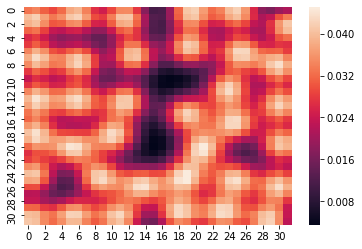

In [48]:
for i,data in enumerate(train_loader,1):
        print(data.shape)
        print(data[0])
        out = CombineModel(data)
        print(out[300][0]-out[200][0])
        #print(out[0][0].shape)
        seaborn.heatmap(dataSet32[300][0].to('cpu').detach().numpy())
        #seaborn.heatmap(dataSet32[100][0].to('cpu').detach().numpy())
        break
        loss = torch.sqrt( nn.MSELoss()(out, dataSet32[(i-1)*batch_size:i*batch_size]) )
        print(loss)
        loss =  (out- dataSet32[(i-1)*batch_size:i*batch_size])/dataSet32[(i-1)*batch_size:i*batch_size]
        loss = loss.squeeze()
        loss = torch.reshape(loss,(loss.shape[0],32*32))
        #print(loss.shape)
        loss = torch.abs(loss)
        loss =loss.mean()
        print(loss)
        #loss.backward()
        #print(out[:,0].shape)
        #loss =  (out- dataSet32[(i-1)*batch_size:i*batch_size])/dataSet32[(i-1)*batch_size:i*batch_size]
        #print(loss.mean())
        

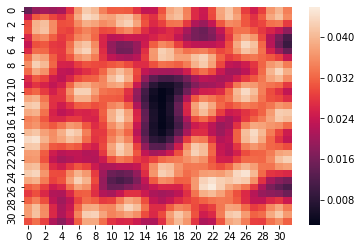

In [47]:
seaborn.heatmap(dataSet32[65000][0].to('cpu').detach().numpy())

In [21]:
import seaborn